# Figure S1P1 Frequency of Events in Distance Category

In [7]:
library(ggplot2)
library(dplyr)
library(RColorBrewer)
top_loci_integrated_distance_summary <- readRDS("~/project/Figure_codes/data/Figure_S1_P1.rds") #FIXME
color_palette <- c("#3578A3", "#4B8F78", "#EA5E2C", "#CDBA2E", "#E69933")

In [8]:
singlecontext_top_loci_table_integrated_distance_filtered_category <- top_loci_integrated_distance_summary %>% filter(cs_coverage_0.95!=0)%>%
                                                                  mutate(
                                                                          distance_category = case_when(
                                                                                                          distance < 10e3 ~ "<10Kb",
                                                                                                          distance >= 10e3 & distance < 50e3 ~ "10Kb~50Kb",
                                                                                                          distance >= 50e3 & distance < 100e3 ~ "50Kb~100Kb",
                                                                                                          distance >= 100e3 & distance < 1e6 ~ "100Kb~1Mb",
                                                                                                          distance >= 1e6 ~ ">1Mb",
                                                                                                       ),
                                                                          distance_category = factor(distance_category, levels = c("<10Kb", "10Kb~50Kb", "50Kb~100Kb", "100Kb~1Mb", ">1Mb"))
                                                                          )
#pdf("single_context_variant_TSS_TES_distance.pdf", width =10, height = 8)
# Group by context and distance category, then calculate frequency
singlecontext_top_loci_table_integrated_distance_filtered_category <- singlecontext_top_loci_table_integrated_distance_filtered_category %>%
  group_by(resource, distance_category) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(resource) %>%
  mutate(frequency = count / sum(count))

# Define the order of categories for the x-axis
singlecontext_top_loci_table_integrated_distance_filtered_category$context <- factor(singlecontext_top_loci_table_integrated_distance_filtered_category$resource, levels = unique(singlecontext_top_loci_table_integrated_distance_filtered_category$resource))

#color_palette <- c("#1f77b4","#2ca02c","#ff7f0e","#d62728","#9467bd")
# Plot
p1 <- ggplot(singlecontext_top_loci_table_integrated_distance_filtered_category, aes(x = resource, y = frequency, fill = distance_category)) +
  geom_bar(stat = "identity", position = "stack") +
  scale_fill_manual(values = rev(color_palette), 
                    name = "Distance", 
                    labels = rev(c("< 10Kb","10Kb ~ 50Kb","50Kb ~ 100Kb","100Kb ~ 1Mb",expression("" >= "1Mb"))),guide = guide_legend(reverse = TRUE)) + 
  labs(
    title = "Frequency of Events in Distance Category",
    x = "Context",
    y = "Frequency",
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1,size = 15),
       plot.title = element_text(hjust = 0.5, size = 25, face = "bold"),
       axis.title = element_text(size = 25, face = "bold"),
       axis.text.y = element_text(size = 20,margin = margin(l = 20)),
       legend.title = element_text(size = 20, face = "bold"),
       legend.text = element_text(size = 15)
    )
#dev.off()

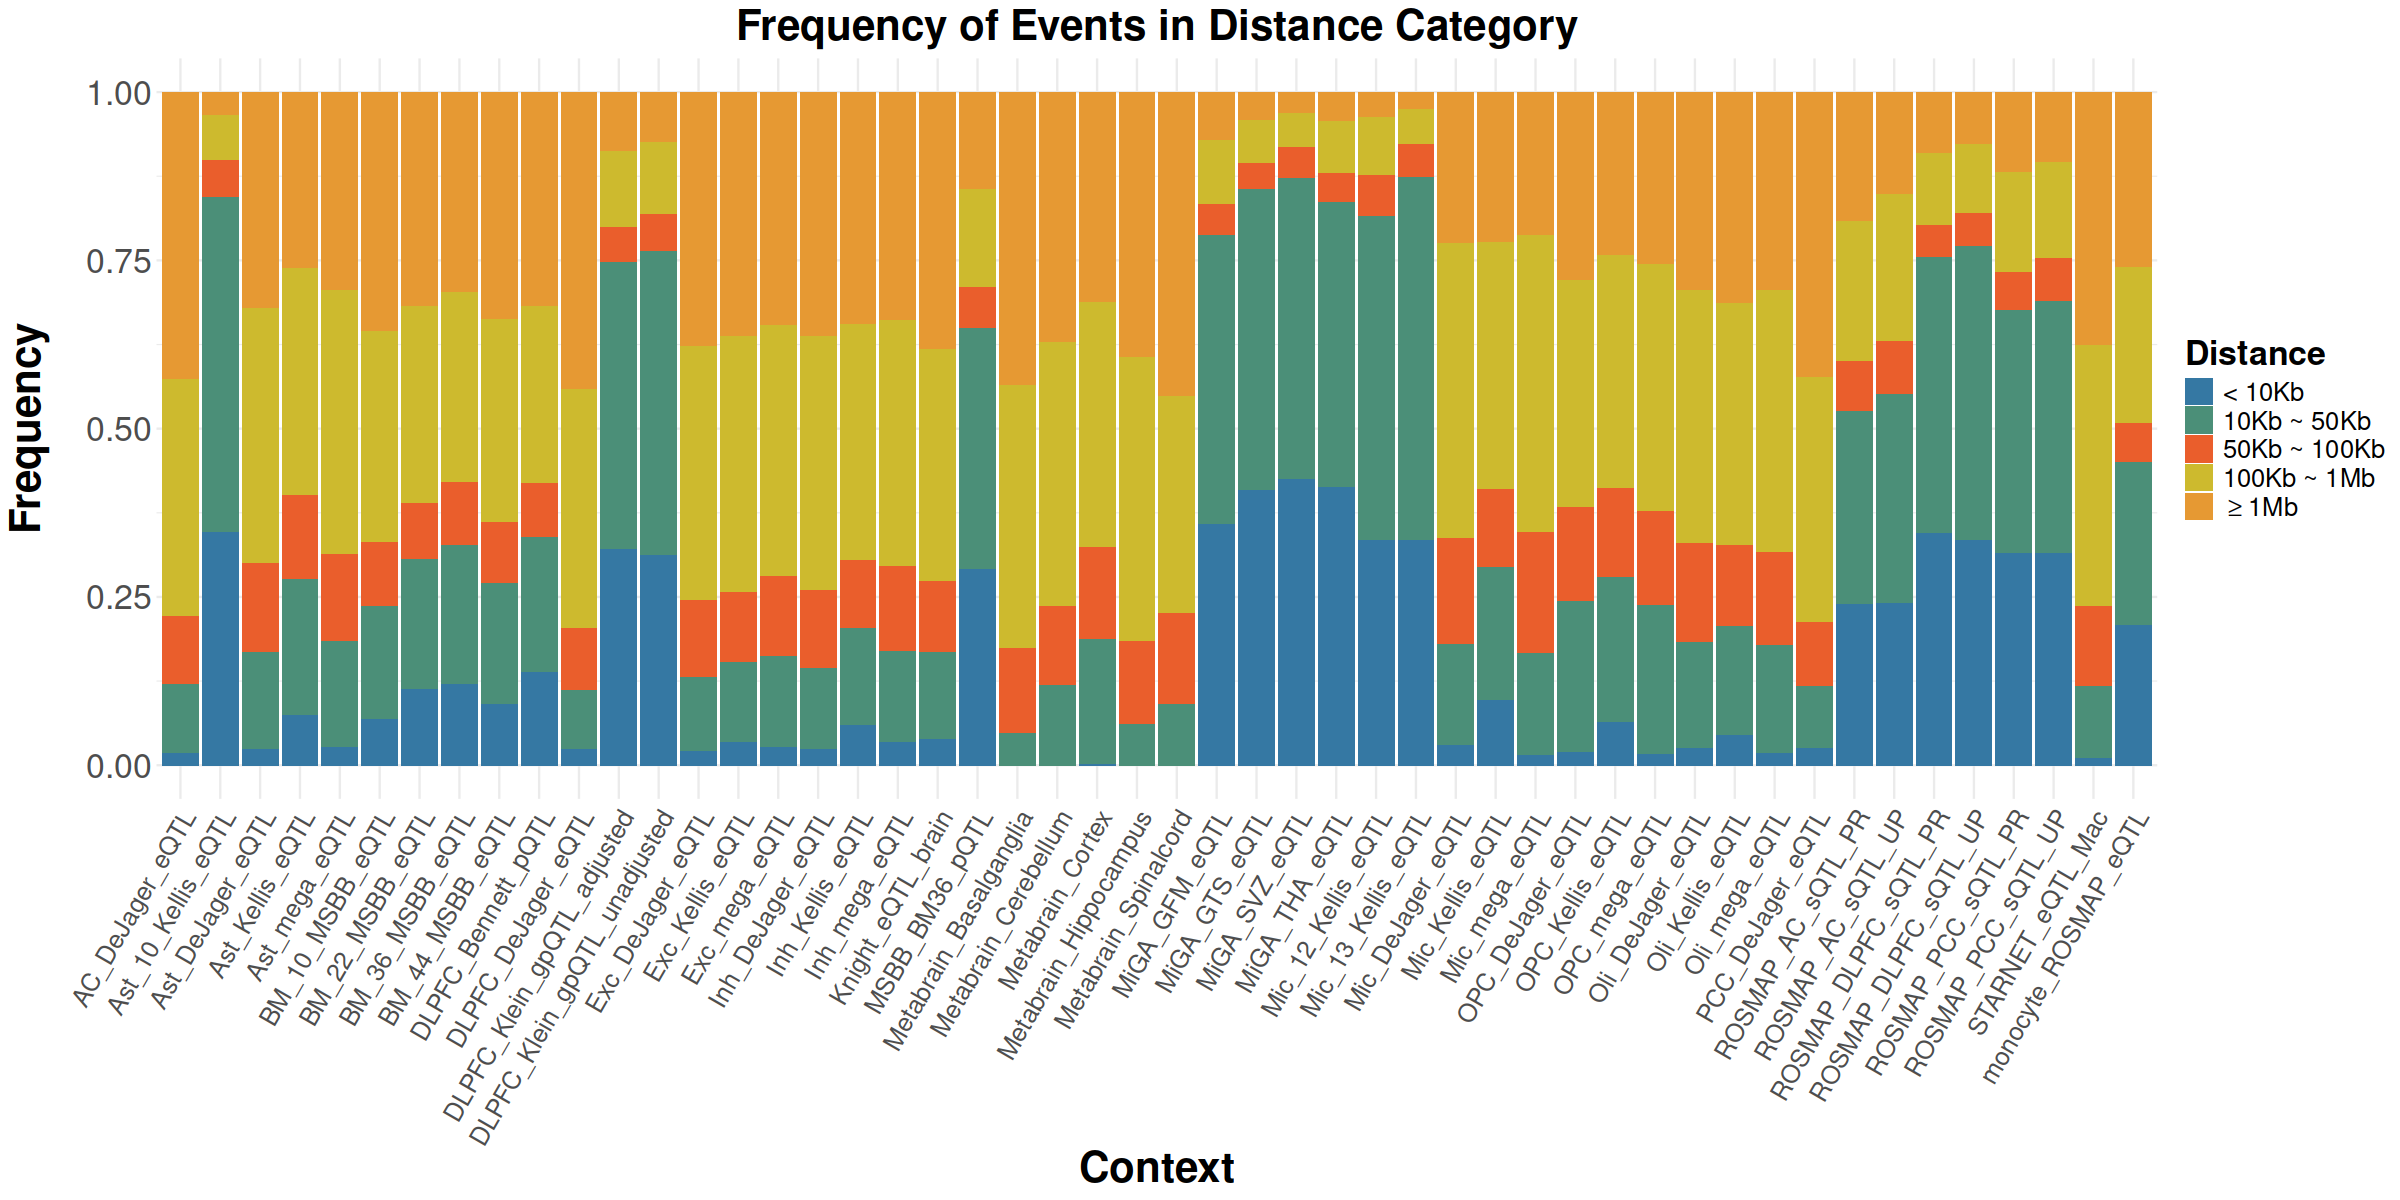

In [3]:
options(repr.plot.width = 20, repr.plot.height = 10)
p1